In [12]:
!pip install geopy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.2 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic
import datetime
import warnings
warnings.filterwarnings("ignore")


In [19]:
# Load the dataset
df = pd.read_csv('uber.csv')

# Display the first few rows
df.head()


,id,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.99951172,40.723217,1.0
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.99471,40.750325,1.0
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0


In [20]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47086 entries, 0 to 47085
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 47086 non-null  int64  
 1   key                47086 non-null  object 
 2   fare_amount        47086 non-null  float64
 3   pickup_datetime    47086 non-null  object 
 4   pickup_longitude   47086 non-null  float64
 5   pickup_latitude    47086 non-null  float64
 6   dropoff_longitude  47086 non-null  object 
 7   dropoff_latitude   47085 non-null  float64
 8   passenger_count    47085 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 3.2+ MB


In [21]:
df.describe()

,id,fare_amount,pickup_longitude,pickup_latitude,dropoff_latitude,passenger_count
count,4.708600e+04,47086.000000,47086.000000,47086.000000,47085.000000,47085.000000
mean,2.768675e+07,11.408889,-72.563408,39.948721,39.953966,1.678836
std,1.602762e+07,10.114802,10.739442,6.001232,5.984397,1.297215
min,4.800000e+01,0.000000,-748.016667,-74.015515,-74.008745,0.000000
25%,1.375962e+07,6.000000,-73.992121,40.734714,40.733646,1.000000
50%,2.764889e+07,8.500000,-73.981847,40.752522,40.752873,1.000000
75%,4.150497e+07,12.500000,-73.967152,40.767040,40.768170,2.000000
max,5.542169e+07,350.000000,40.774042,45.031653,45.031598,6.000000


In [25]:
# Missing values per column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 id                   0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [24]:
df.dropna(inplace=True)

In [30]:
df['dropoff_longitude'] = df['dropoff_longitude'].astype('float64')

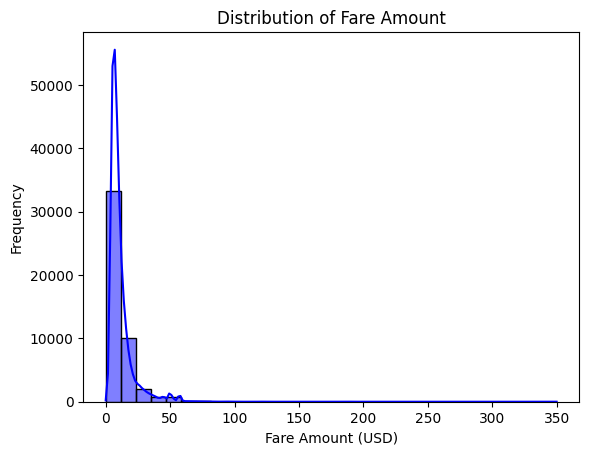

In [23]:
# Distribution of fare_amount
sns.histplot(df['fare_amount'], kde=True, bins=30, color="blue")
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Frequency")
plt.show()


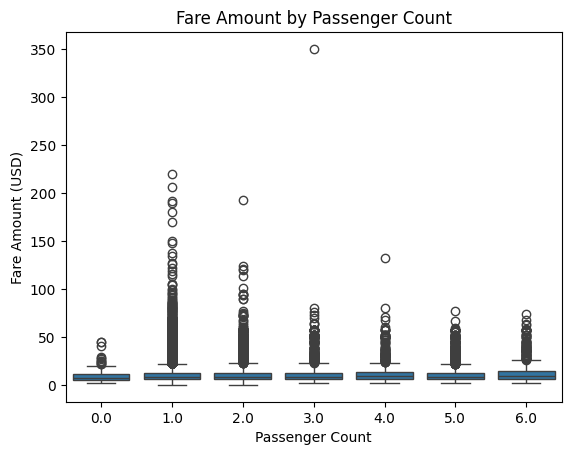

In [26]:
# Boxplot of fare_amount by passenger_count
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title("Fare Amount by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Fare Amount (USD)")
plt.show()


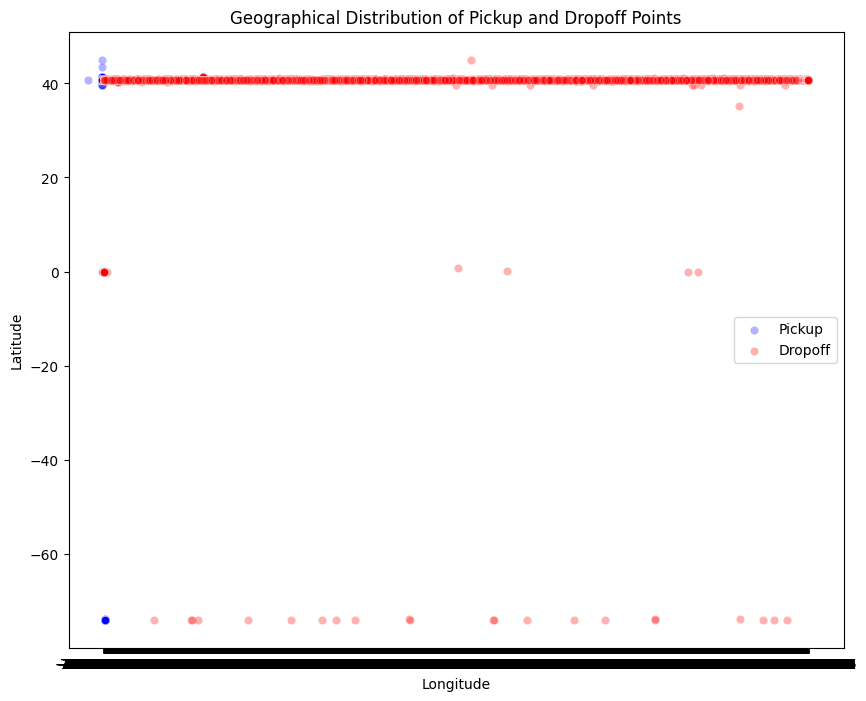

In [27]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['pickup_longitude'], y=df['pickup_latitude'], alpha=0.3, label='Pickup', color='blue')
sns.scatterplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], alpha=0.3, label='Dropoff', color='red')
plt.title("Geographical Distribution of Pickup and Dropoff Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


## **Data Preprocessing**

In [31]:
# Remove extreme fare values
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 500)]

# Filter valid latitudes and longitudes
df = df[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['dropoff_longitude'].between(-180, 180))
]


In [32]:
# Convert pickup_datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract features from pickup_datetime
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday


## **Calculate Distance**
Using geodesic distance from geopy to calculate the straight-line distance between pickup and dropoff locations.

In [33]:
# Function to calculate geodesic distance
def calculate_distance(row):
    return geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).km

# Add a distance column
df['distance_km'] = df.apply(calculate_distance, axis=1)


In [34]:
# Drop unused columns
df = df.drop(['key', 'pickup_datetime'], axis=1)


In [35]:
# Define features and target variable
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)


In [37]:
# Random Forest evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")


Random Forest MSE: 22.02
Random Forest R²: 0.78


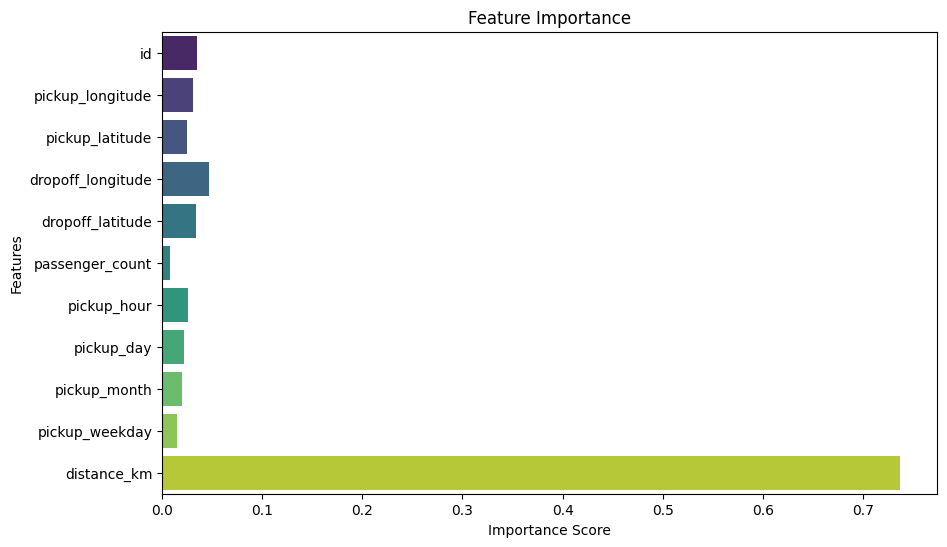

In [38]:
# Feature importance
feature_importance = rf_model.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


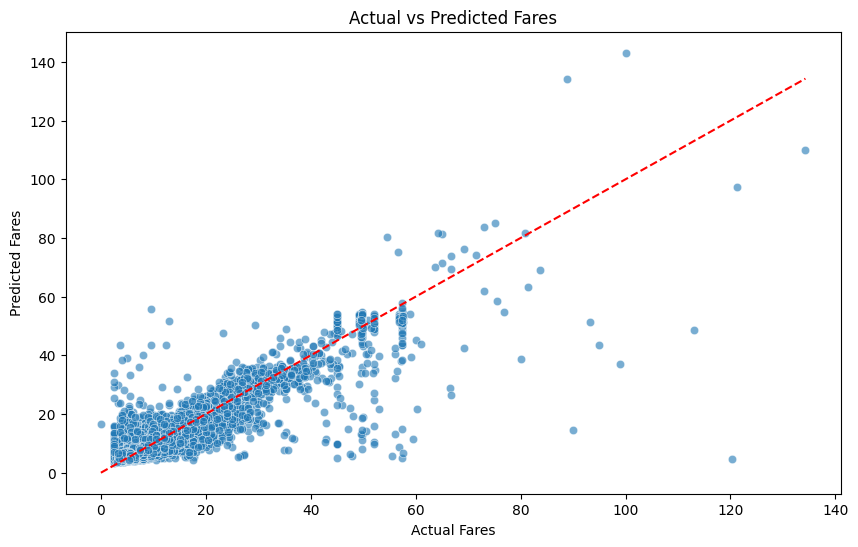

In [39]:
# Plot predicted vs actual fares
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Actual vs Predicted Fares")
plt.xlabel("Actual Fares")
plt.ylabel("Predicted Fares")
plt.show()
